In [61]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os


In [62]:
import dask
import dask.dataframe as dd

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

# Data Explorations

In [64]:
#this function of reading files and making them dask dataframes only works for a certain filename format that is data_YEAR_MONTH like data_21_12 
def merge_datasets_of_year(year, starting_month):
    merged_df = pd.DataFrame()
    for month in range(starting_month, 13):
        if month < 10:
            month = "0"+str(month)
        file_name = str(year)+"_"+str(month)+".csv"
        df_name = "data_"+str(year)+"_"+str(month)
        #dask dataframe syntax here: 
        new_df = dd.read_csv(file_name,sep=',', dtype={'last_reported': 'float64'})
        merged_df = dd.concat([merged_df, new_df]).reset_index(drop=True)
    return merged_df

In [65]:
data_2019 = merge_datasets_of_year(2019, 3)


In [66]:
data_2020 = merge_datasets_of_year(2020, 1)


In [67]:
data_2021 = merge_datasets_of_year(2021, 1)


In [68]:
data_2022 = merge_datasets_of_year(2022, 1)


In [69]:
def add_additional_columns_df(df):
    grouping_columns = ['station_id','year','month','day', 'hour']
    availability_last_reported_hourly_df = df.groupby(grouping_columns)['availability'].last().reset_index().compute()
    availability_mean_hourly_df = df.groupby(grouping_columns)['availability'].mean().reset_index().compute()

    availability_last_reported_hourly_df = availability_last_reported_hourly_df.rename(columns={'availability': 'last_availability_report_for_hour'})
    availability_mean_hourly_df = availability_mean_hourly_df.rename(columns={'availability': 'mean_availability_for_hour'})

    # Define a lambda function to assign the last value for each group to every row
    df = dd.merge(availability_last_reported_hourly_df,  df, on=grouping_columns)
    df = dd.merge(availability_mean_hourly_df, df, on=grouping_columns)
    return df

In [70]:
def preprocessing_year_df(df):
    df['last_reported'] = dd.to_datetime(df['last_reported'], unit='s')
    df['year'] = df['last_reported'].dt.year
    df['hour'] = df['last_reported'].dt.hour
    df['month'] = df['last_reported'].dt.month
    df['day'] = df['last_reported'].dt.day
    df['minute'] = df['last_reported'].dt.minute
    df['weekday'] = df['last_reported'].dt.weekday
    df['availability'] = df['num_docks_available'] / (df['num_bikes_available']+df['num_docks_available']) * 100
    df = df[df["status"]=="IN_SERVICE"]
    
    df = add_additional_columns_df(df)
    
    return df



In [71]:
data_2019 = preprocessing_year_df(data_2019)
data_2020 = preprocessing_year_df(data_2020)
data_2021 = preprocessing_year_df(data_2021)
data_2022 = preprocessing_year_df(data_2022)

In [72]:
grouping_columns = ['station_id','year','month','day', 'hour']


In [14]:
data = dd.concat([data_2019, data_2020, data_2021, data_2022]).reset_index(drop=True)

In [77]:
len(data_2022)

52857191

In [21]:
len(nan_data)

179527442

In [78]:
nan_data = data.isna().compute()

In [79]:
nan_data

,station_id,year,month,day,hour,mean_availability_for_hour,last_availability_report_for_hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,...,is_returning,last_reported,is_charging_station,status,last_updated,ttl,minute,weekday,availability,traffic
4359,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4360,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4361,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4362,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091151,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1091152,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1091153,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1091154,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:

# Check for missing values
is_missing = data.isnull() | data.isna()

# Compute the sum of missing values
sum_missing = is_missing.sum()

# Compute the percentage of missing values
percent_missing = (sum_missing * 100 / len(data)).round(1)

# Create a DataFrame to store the missing value statistics
missing_value_df = dd.from_pandas(pd.DataFrame({'column_name': data.columns}), npartitions=1)
missing_value_df['sum_missing'] = sum_missing
missing_value_df['percent_missing'] = percent_missing

# Sort the DataFrame by sum of missing values
missing_value_train_set = missing_value_df.compute().sort_values('sum_missing', ascending=False)

# Print the missing value statistics
print(missing_value_train_set)

TypeError: '<' not supported between instances of 'str' and 'int'

In [86]:
df_grouped = data.groupby(grouping_columns)["availability", "last_availability_report_for_hour", 'weekday'].mean().reset_index().compute()


In [26]:
df_grouped.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'availability',
       'last_availability_report_for_hour', 'weekday'],
      dtype='object')

In [ ]:
len(df_grouped)

In [ ]:
df_grouped.columns

In [27]:
df_grouped['previous_hour_last_availability'] = df_grouped['last_availability_report_for_hour'].shift(1)
df_grouped = df_grouped.drop('last_availability_report_for_hour', axis=1)

In [28]:
df_grouped.tail(30)

,station_id,year,month,day,hour,availability,weekday,previous_hour_last_availability
71199,519,2021.0,12.0,5.0,9.0,73.863636,6.0,72.727273
71200,519,2021.0,12.0,5.0,10.0,81.060606,6.0,77.272727
71201,519,2021.0,12.0,5.0,11.0,81.818182,6.0,81.818182
71202,519,2021.0,12.0,5.0,12.0,84.848485,6.0,81.818182
71203,519,2021.0,12.0,5.0,13.0,81.060606,6.0,86.363636
71204,519,2021.0,12.0,5.0,14.0,81.818182,6.0,81.818182
71205,519,2021.0,12.0,5.0,15.0,86.742424,6.0,81.818182
71206,519,2021.0,12.0,5.0,16.0,93.560606,6.0,90.909091
71207,519,2021.0,12.0,5.0,17.0,98.863636,6.0,95.454545
71208,519,2021.0,12.0,5.0,18.0,96.590909,6.0,95.454545


In [55]:
expected_hours = pd.DataFrame({'hour': range(0, 24)})

# Get the unique combinations of station_id, year, month, and day from the original DataFrame
unique_combinations = df_grouped[['station_id', 'year', 'month', 'day', 'weekday']].drop_duplicates()

# Cross-join the unique combinations with the expected hours
merged_df = pd.merge(unique_combinations, expected_hours, how='cross')

merged_df = pd.merge(merged_df, df_grouped, on=['station_id', 'year', 'month', 'day', 'hour', 'weekday'], how='left')




In [56]:
merged_df.head()

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability
0,1,2021.0,11.0,29.0,0.0,0,NaN,NaN
1,1,2021.0,11.0,29.0,0.0,1,NaN,NaN
2,1,2021.0,11.0,29.0,0.0,2,NaN,NaN
3,1,2021.0,11.0,29.0,0.0,3,NaN,NaN
4,1,2021.0,11.0,29.0,0.0,4,NaN,NaN


In [57]:
filtered_df = merged_df[merged_df['availability'].isna()==True][merged_df['previous_hour_last_availability'].isna()==False]



/var/folders/9h/_2bn_v7j5b783n0g3l3zlzyh0000gn/T/ipykernel_77441/4108392717.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = merged_df[merged_df['availability'].isna()==True][merged_df['previous_hour_last_availability'].isna()==False]


In [58]:
filtered_df

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability


In [59]:
len(filtered_df)

0

In [60]:
filtered_df.index

Int64Index([], dtype='int64')

In [26]:
merged_df.iloc[filtered_df.index]['availability'] = merged_df['previous_hour_last_availability']

/var/folders/9h/_2bn_v7j5b783n0g3l3zlzyh0000gn/T/ipykernel_60261/3226379072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.iloc[filtered_df.index]['availability'] = merged_df['previous_hour_last_availability']


In [27]:
merged_df

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability
0,1,2019.0,3.0,28.0,3.0,0,NaN,NaN
1,1,2019.0,3.0,28.0,3.0,1,NaN,NaN
2,1,2019.0,3.0,28.0,3.0,2,NaN,NaN
3,1,2019.0,3.0,28.0,3.0,3,NaN,NaN
4,1,2019.0,3.0,28.0,3.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...
15164683,519,2022.0,12.0,31.0,5.0,19,76.041667,83.333333
15164684,519,2022.0,12.0,31.0,5.0,20,66.666667,70.833333
15164685,519,2022.0,12.0,31.0,5.0,21,59.027778,62.500000
15164686,519,2022.0,12.0,31.0,5.0,22,58.333333,58.333333


In [28]:
merged_df[merged_df['availability'].isna()]

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability
0,1,2019.0,3.0,28.0,3.0,0,NaN,NaN
1,1,2019.0,3.0,28.0,3.0,1,NaN,NaN
2,1,2019.0,3.0,28.0,3.0,2,NaN,NaN
3,1,2019.0,3.0,28.0,3.0,3,NaN,NaN
4,1,2019.0,3.0,28.0,3.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...
15151051,437,2022.0,12.0,30.0,4.0,19,NaN,NaN
15151052,437,2022.0,12.0,30.0,4.0,20,NaN,NaN
15156995,474,2022.0,12.0,26.0,0.0,11,NaN,NaN
15156996,474,2022.0,12.0,26.0,0.0,12,NaN,NaN


In [29]:
merged_df = merged_df.dropna()

In [30]:
merged_df

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability
18,1,2019.0,3.0,28.0,3.0,18,43.000000,46.666667
19,1,2019.0,3.0,28.0,3.0,19,37.500000,50.000000
20,1,2019.0,3.0,28.0,3.0,20,8.333333,26.666667
21,1,2019.0,3.0,28.0,3.0,21,3.333333,0.000000
22,1,2019.0,3.0,28.0,3.0,22,1.388889,6.666667
...,...,...,...,...,...,...,...,...
15164683,519,2022.0,12.0,31.0,5.0,19,76.041667,83.333333
15164684,519,2022.0,12.0,31.0,5.0,20,66.666667,70.833333
15164685,519,2022.0,12.0,31.0,5.0,21,59.027778,62.500000
15164686,519,2022.0,12.0,31.0,5.0,22,58.333333,58.333333


In [31]:
#create metadata columns

# we sort the data 
merged_df = merged_df.sort_values(by=['station_id', 'year', 'month', 'day', 'hour'])

# we create columns for the ocupation in the same station for the previous 4 hours
merged_df['availability_1h_before'] = merged_df.groupby('station_id')['availability'].shift(1)
merged_df['availability_2h_before'] = merged_df.groupby('station_id')['availability'].shift(2)
merged_df['availability_3h_before'] = merged_df.groupby('station_id')['availability'].shift(3)
merged_df['availability_4h_before'] = merged_df.groupby('station_id')['availability'].shift(4)


df_grouped_columns = merged_df.columns

# Delete the infinity and NaN values

df_grouped = merged_df.dropna()
#how do we fill when it is the first row for a given station, year, mnth, day? The previous station? we need to check that


In [32]:
df_grouped = df_grouped.drop('previous_hour_last_availability', axis=1)

In [33]:
df_grouped

,station_id,year,month,day,weekday,hour,availability,availability_1h_before,availability_2h_before,availability_3h_before,availability_4h_before
22,1,2019.0,3.0,28.0,3.0,22,1.388889,3.333333,8.333333,37.500000,43.000000
23,1,2019.0,3.0,28.0,3.0,23,0.555556,1.388889,3.333333,8.333333,37.500000
24,1,2019.0,3.0,29.0,4.0,0,2.873563,0.555556,1.388889,3.333333,8.333333
25,1,2019.0,3.0,29.0,4.0,1,0.000000,2.873563,0.555556,1.388889,3.333333
26,1,2019.0,3.0,29.0,4.0,2,0.000000,0.000000,2.873563,0.555556,1.388889
...,...,...,...,...,...,...,...,...,...,...,...
14607531,532,2022.0,11.0,13.0,6.0,3,0.000000,0.000000,0.000000,0.000000,0.000000
14607532,532,2022.0,11.0,13.0,6.0,4,0.000000,0.000000,0.000000,0.000000,0.000000
14607533,532,2022.0,11.0,13.0,6.0,5,0.000000,0.000000,0.000000,0.000000,0.000000
14607534,532,2022.0,11.0,13.0,6.0,6,0.000000,0.000000,0.000000,0.000000,0.000000


# Data Exploration / Visualization

### Hourly Availibility

In [456]:
data = data[data["year"]>2018]

In [55]:
#let's see availibility regarding hours in different years

year_hour_availability = data.groupby(["year", "hour"])["availability"].mean().reset_index().compute()
pivoted_df = year_hour_availability.pivot(index="hour", columns="year", values="availability")


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


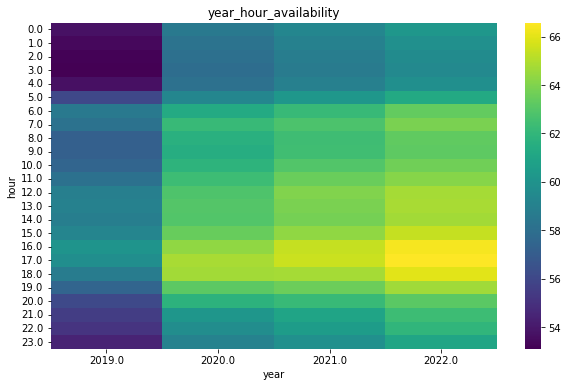

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_df, cmap='viridis')

plt.title('year_hour_availability')
plt.savefig('year_hour_availability.png')



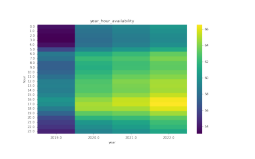

In [59]:
import matplotlib.image as mpimg

img = mpimg.imread('year_hour_availability.png')

original_width, original_height, _ = img.shape
plt.figure(figsize=(original_width / 100, original_height / 100))

# Display the image
plt.imshow(img)
plt.axis('off')  # Optional: Hide the axes and ticks
plt.show()

* There is a similar pattern of hourly availibility pattern across the years. But, each year more availibility in general

In [60]:
year_availability = data.groupby(["year"])["availability"].mean().reset_index().compute()
year_availability

,year,availability
0,2019.0,56.778904
1,2020.0,61.284364
2,2021.0,62.078170
3,2022.0,63.055793


*Avarage availity seems to decrease each year. 
       -increased park slots and not that much new bikes? OR
       -more bikes in circulation each year?


In [111]:
#what about hours across months?

month_hour_availability = data.groupby(["month", "hour"])["availability"].mean().reset_index().compute()
pivoted_month_hour = month_hour_availability.pivot(index="hour", columns="month", values="availability")


<AxesSubplot:xlabel='month', ylabel='hour'>

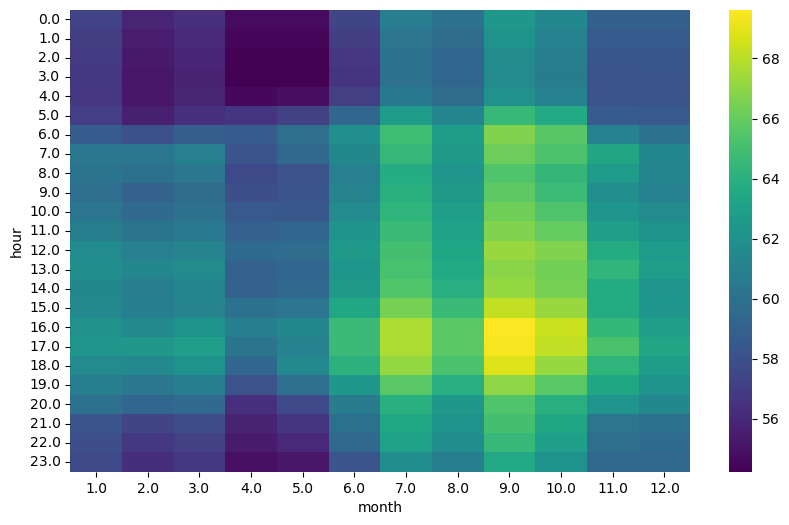

In [135]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_month_hour, cmap='viridis')

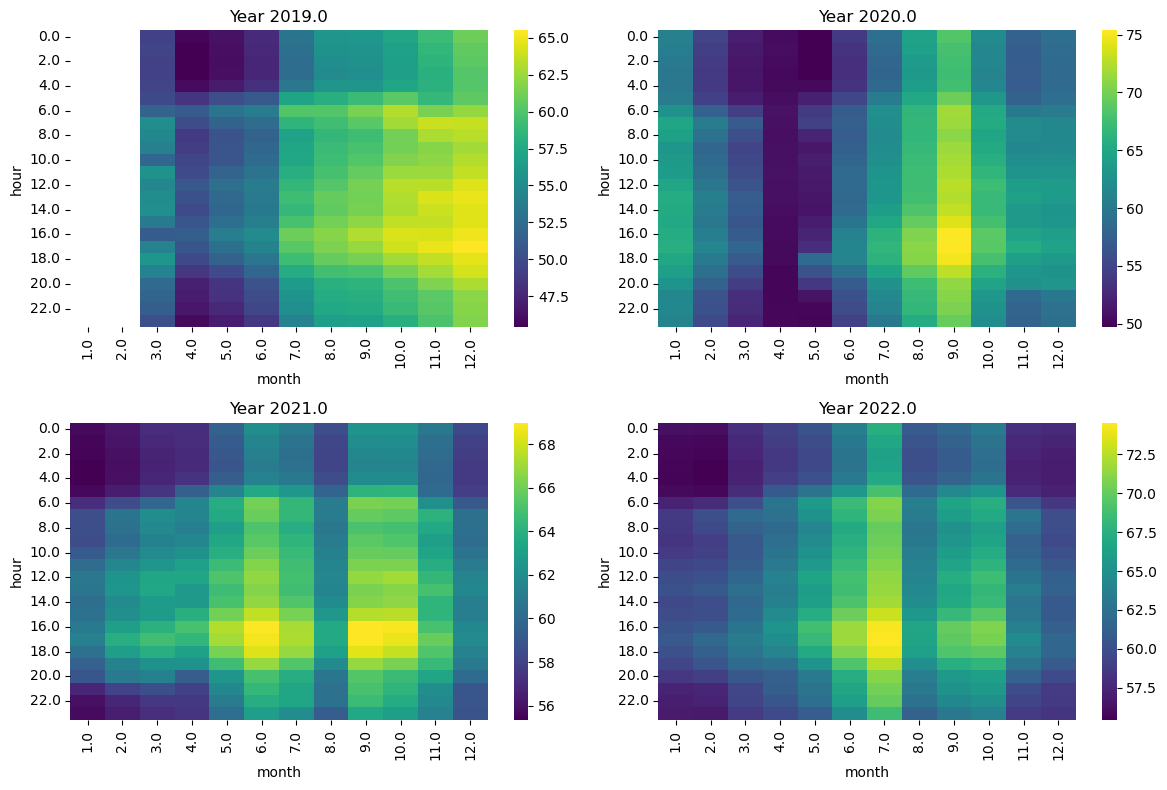

In [136]:
year_month_hour_availability = data.groupby(["year", "month", "hour"])["availability"].mean().reset_index()


# Convert the "month" column to categorical data type
year_month_hour_availability["month"] = year_month_hour_availability["month"].astype('category')
year_month_hour_availability["month"] = year_month_hour_availability["month"].cat.as_known()


# Compute the pivot tables for each year
pivot_tables = []
years = year_month_hour_availability["year"].unique().compute()
for year in years:
    year_df = year_month_hour_availability[year_month_hour_availability["year"] == year]
    pivot_table = year_df.pivot_table(index="hour", columns="month", values="availability").compute()
    pivot_tables.append(pivot_table)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the subplots and plot the pivot tables
for i, ax in enumerate(axes):
    year = years[i]
    pivot_table = pivot_tables[i]
    sns.heatmap(pivot_table, cmap='viridis', ax=ax)
    ax.set_title(f'Year {year}')

# Remove any extra subplots
if len(years) < len(axes):
    for j in range(len(years), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


There is no constancy of hourly availibility of parking slots depending on the month across years. Months have different behavior in different years.

2021 and 2022 have a more similar and more coherent behaviour. 2019 and 2020 could be effect by the pandemi. We could consider not using 2019 and 2020 for training. Or we could exclude some part of 2020

In [138]:
#what about weekdays x hours?

weekday_hour_availability = data.groupby(["weekday", "hour"])["availability"].mean().reset_index().compute()
pivoted_weekday_hour = weekday_hour_availability.pivot(index="hour", columns="weekday", values="availability")


<AxesSubplot:xlabel='weekday', ylabel='hour'>

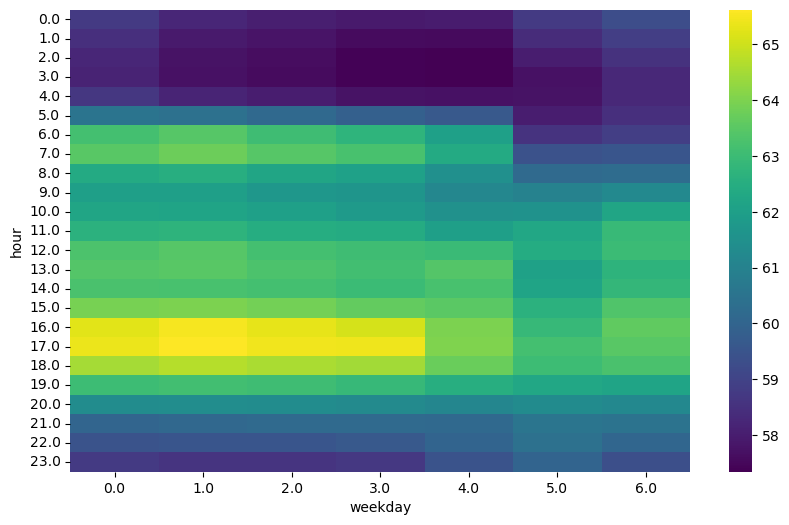

In [139]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_weekday_hour, cmap='viridis')

From Monday to Thursday, we have a very similar behavior. Friday differs from other weekdays though still have some similarity. We could group weekdays as Weekdays(Monday to Thursday), Friday, and Weekend(Saturday-Sunday)

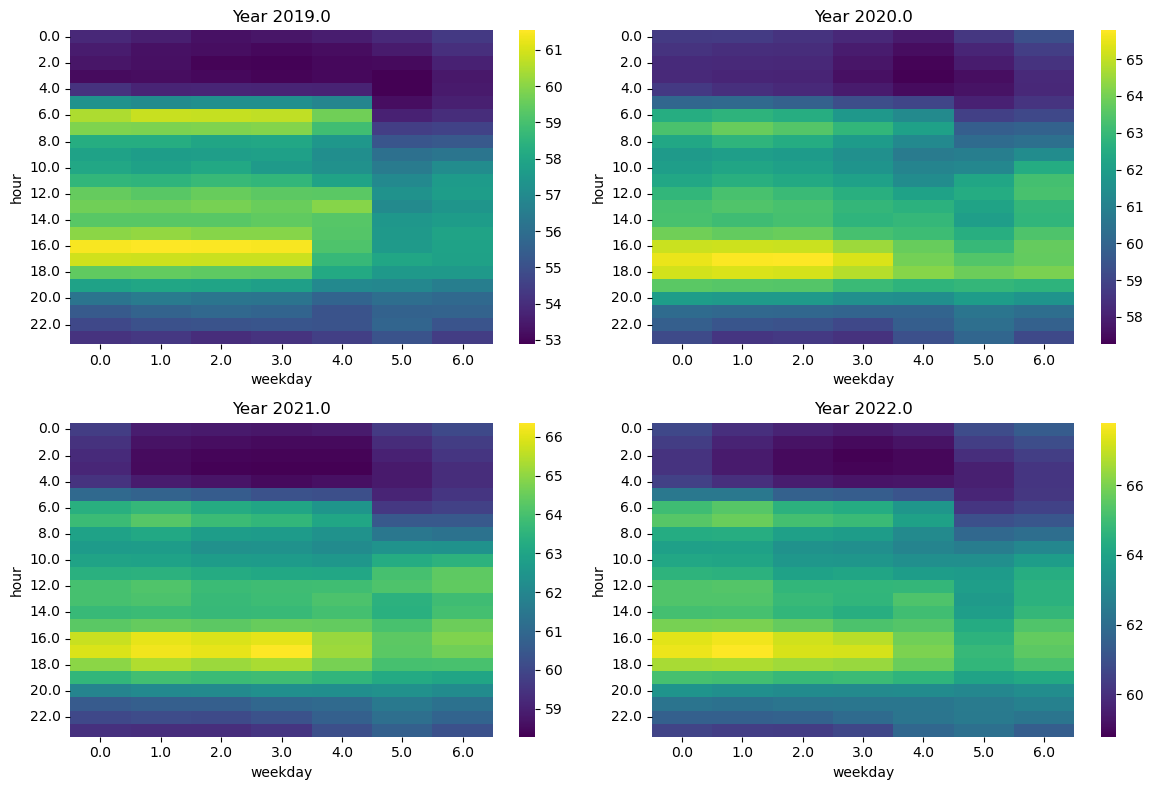

In [140]:
year_weekday_hour_availability = data.groupby(["year", "weekday", "hour"])["availability"].mean().reset_index()


# Convert the "month" column to categorical data type
year_weekday_hour_availability["weekday"] = year_weekday_hour_availability["weekday"].astype('category')
year_weekday_hour_availability["weekday"] = year_weekday_hour_availability["weekday"].cat.as_known()


# Compute the pivot tables for each year
pivot_tables = []
years = year_weekday_hour_availability["year"].unique().compute()
for year in years:
    year_df = year_weekday_hour_availability[year_weekday_hour_availability["year"] == year]
    pivot_table = year_df.pivot_table(index="hour", columns="weekday", values="availability").compute()
    pivot_tables.append(pivot_table)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the subplots and plot the pivot tables
for i, ax in enumerate(axes):
    year = years[i]
    pivot_table = pivot_tables[i]
    sns.heatmap(pivot_table, cmap='viridis', ax=ax)
    ax.set_title(f'Year {year}')

# Remove any extra subplots
if len(years) < len(axes):
    for j in range(len(years), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


similar patterns across years of hourly activity for different weekdays. Covid did not effect this

### Availibility by weekday

In [150]:
#what about weekdays across months?

month_weekday_availability = data.groupby(["weekday", "month"])["availability"].mean().reset_index().compute()
pivoted_month_weekday = month_weekday_availability.pivot(index="weekday", columns="month", values="availability")


<AxesSubplot:xlabel='month', ylabel='weekday'>

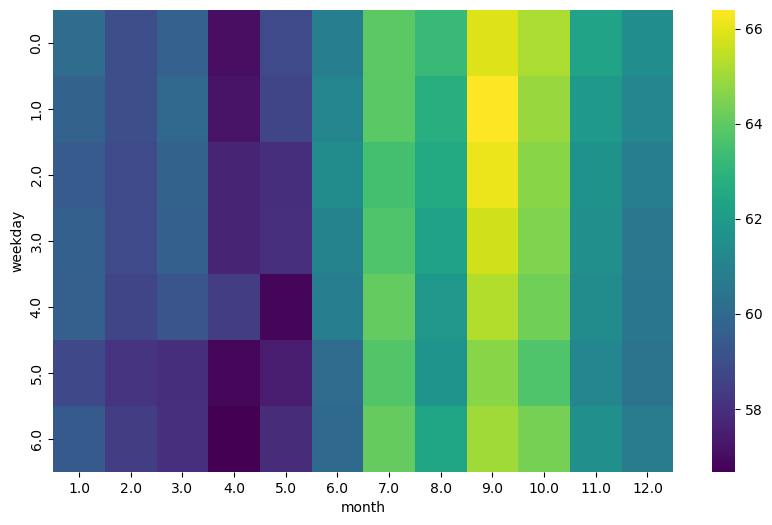

In [151]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_month_weekday, cmap='viridis')

No consistency of availibility on week days across months. Months seem to have. astronger effect on availibility than weekdays

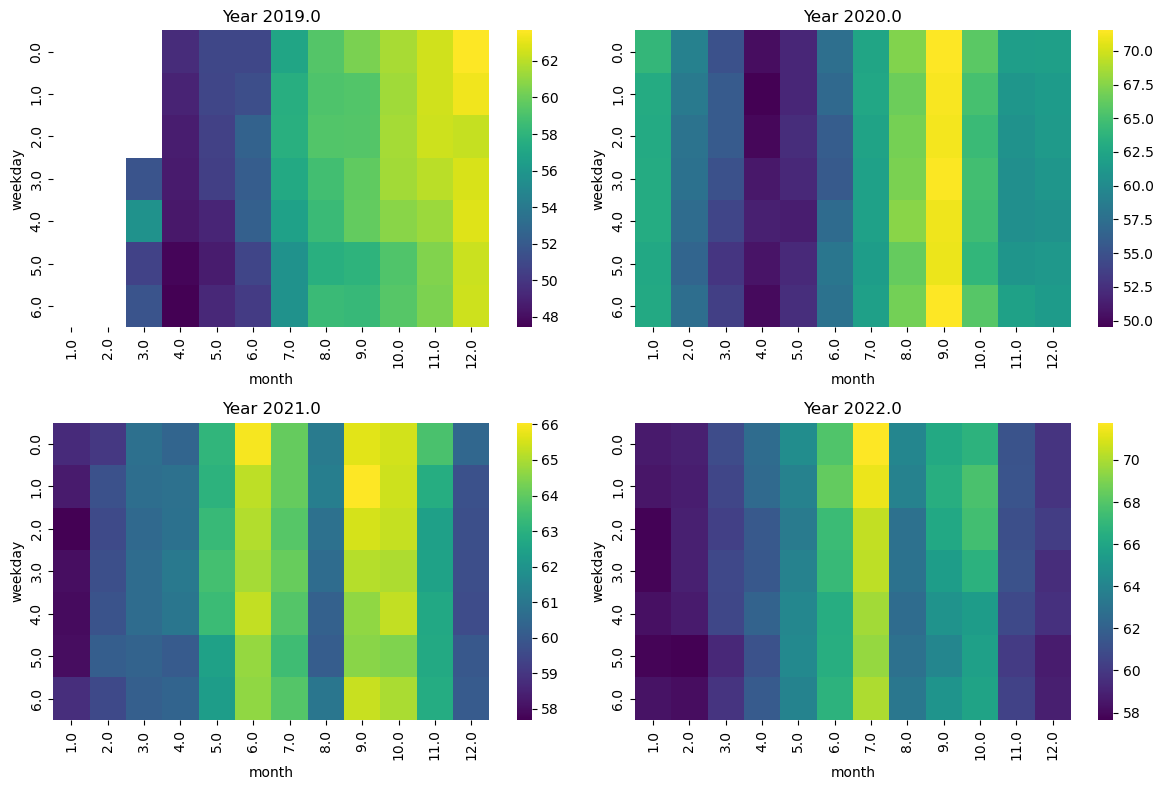

In [31]:
year_month_weekday_availability = data.groupby(["year", "month", "weekday"])["availability"].mean().reset_index()


# Convert the "month" column to categorical data type
year_month_weekday_availability["month"] = year_month_weekday_availability["month"].astype('category')
year_month_weekday_availability["month"] = year_month_weekday_availability["month"].cat.as_known()


# Compute the pivot tables for each year
pivot_tables = []
years = year_month_weekday_availability["year"].unique().compute()
for year in years:
    year_df = year_month_weekday_availability[year_month_weekday_availability["year"] == year]
    pivot_table = year_df.pivot_table(index="weekday", columns="month", values="availability").compute()
    pivot_tables.append(pivot_table)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the subplots and plot the pivot tables
for i, ax in enumerate(axes):
    year = years[i]
    pivot_table = pivot_tables[i]
    sns.heatmap(pivot_table, cmap='viridis', ax=ax)
    ax.set_title(f'Year {year}')

# Remove any extra subplots
if len(years) < len(axes):
    for j in range(len(years), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


Month seems to have a stronger effect on availibility than weekday

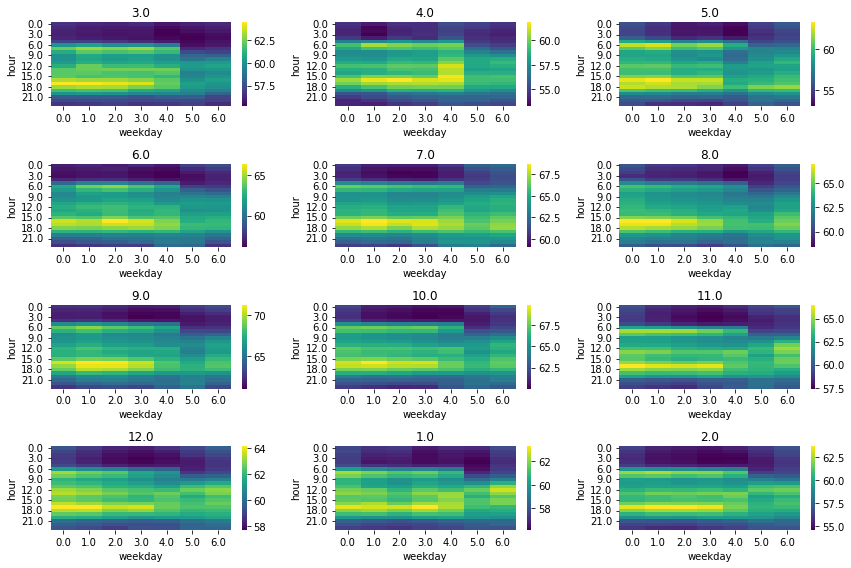

In [61]:
month_weekday_hour_availability = data.groupby(["month", "weekday", "hour"])["availability"].mean().reset_index()


# Convert the "month" column to categorical data type
month_weekday_hour_availability["weekday"] = month_weekday_hour_availability["weekday"].astype('category')
month_weekday_hour_availability["weekday"] = month_weekday_hour_availability["weekday"].cat.as_known()


# Compute the pivot tables for each year
pivot_tables = []
months = month_weekday_hour_availability["month"].unique().compute()
for month in months:
    month_df = month_weekday_hour_availability[month_weekday_hour_availability["month"] == month]
    pivot_table = month_df.pivot_table(index="hour", columns="weekday", values="availability").compute()
    pivot_tables.append(pivot_table)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the subplots and plot the pivot tables
for i, ax in enumerate(axes):
    month = months[i]
    pivot_table = pivot_tables[i]
    sns.heatmap(pivot_table, cmap='viridis', ax=ax)
    ax.set_title(f'{month}')

# Remove any extra subplots
if len(months) < len(axes):
    for j in range(len(months), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [145]:
#what about weekdays across years?

year_weekday_availability = data.groupby(["year", "weekday"])["availability"].mean().reset_index().compute()
pivoted_year_weekday = year_weekday_availability.pivot(index="year", columns="weekday", values="availability")


<AxesSubplot:xlabel='weekday', ylabel='year'>

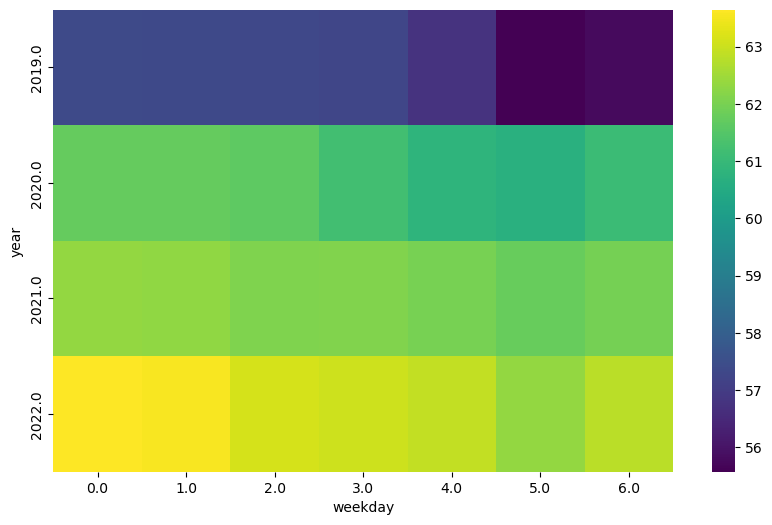

In [148]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_year_weekday, cmap='viridis')

In [141]:
df_grouped.head()

,station_id,year,month,day,hour,availability,availability_1h_before,availability_2h_before,availability_3h_before,availability_4h_before
4,1,2019.0,3.0,28.0,21.0,3.333333,8.333333,37.500000,43.000000,46.666667
5,1,2019.0,3.0,28.0,22.0,1.388889,3.333333,8.333333,37.500000,43.000000
6,1,2019.0,3.0,28.0,23.0,0.555556,1.388889,3.333333,8.333333,37.500000
7,1,2019.0,3.0,29.0,0.0,2.873563,0.555556,1.388889,3.333333,8.333333
8,1,2019.0,3.0,29.0,1.0,0.000000,2.873563,0.555556,1.388889,3.333333


In [457]:
data.columns

Index(['station_id', 'year', 'month', 'day', 'hour',
       'mean_availability_for_hour', 'last_availability_report_for_hour',
       'num_bikes_available', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl', 'minute',
       'weekday', 'availability', 'traffic'],
      dtype='object')

# Station Data 

In [87]:
def get_time_columns(df):
    df["last_updated"] = dd.to_datetime(df["last_updated"], unit='s')
    df['year'] = df['last_updated'].dt.year
    df['hour'] = df['last_updated'].dt.hour
    df['month'] = df['last_updated'].dt.month
    df['day'] = df['last_updated'].dt.day
    
    return df

In [114]:
#this function of reading files and making them dask dataframes only works for a certain filename format that is data_YEAR_MONTH_EST like 2019_02_EST 
def merge_station_datasets_of_year(year, starting_month):
    stations_merged_df = pd.DataFrame()
    for month in range(starting_month, 13):
        if month < 10:
            month = "0"+str(month)
        file_name = str(year)+"_"+str(month)+"_EST.csv"
        df_name = "data_"+str(year)+"_"+str(month)
        #dask dataframe syntax here: 
        new_df = dd.read_csv(file_name,sep=',', encoding= 'unicode_escape', dtype=str)
        stations_merged_df = dd.concat([stations_merged_df, new_df]).reset_index(drop=True)
        
    return stations_merged_df

In [89]:
stations_2019 = merge_station_datasets_of_year(2019, 3)
stations_2020 = merge_station_datasets_of_year(2020, 1)
stations_2021 = merge_station_datasets_of_year(2021, 1)
stations_2022 = merge_station_datasets_of_year(2022, 1)


In [90]:
stations_2019.columns

Index(['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'post_code', 'capacity', 'last_updated', 'ttl',
       'cross_street', 'nearby_distance'],
      dtype='object')

In [91]:
def preprocessing_station_df(df):
    df = get_time_columns(df)
    columns_to_keep = ["station_id", "lat", "lon", "altitude", "post_code", "capacity", "last_updated", 'year', 'hour', 'month', 'day']
    df = df[columns_to_keep]
    df = df.drop('last_updated', axis=1)
    return df


In [92]:
stations_2019 = preprocessing_station_df(stations_2019)
stations_2020 = preprocessing_station_df(stations_2020)
stations_2021 = preprocessing_station_df(stations_2021)
stations_2022 = preprocessing_station_df(stations_2022)


#when I try to convert them to int or float, I get error. When I leave the columns as string datatypes, there is no problem.

In [93]:
stations_2019.dtypes

station_id    object
lat           object
lon           object
altitude      object
post_code     object
capacity      object
year           int64
hour           int64
month          int64
day            int64
dtype: object

In [94]:
stations_2020.tail(n=20)

,station_id,lat,lon,altitude,post_code,capacity,year,hour,month,day
490604,500,41.4119568,2.1447518,102,8023,27,2020,22,12,31
490605,501,41.4052698,2.1420204,95,8023,16,2020,22,12,31
490606,502,41.4074444,2.1492066,88,8023,19,2020,22,12,31
490607,503,41.4095926,2.1524953,105,8024,30,2020,22,12,31
490608,504,41.4092333,2.1557747,87,8024,28,2020,22,12,31
490609,505,41.4145614,2.1658677,118,8024,27,2020,22,12,31
490610,506,41.4191957,2.1718497,107,8041,15,2020,22,12,31
490611,507,41.4107641,2.1640965,81,8024,24,2020,22,12,31
490612,508,41.4090922,2.1656378,70,8025,27,2020,22,12,31
490613,509,41.3989713,2.1606736,46,8012,28,2020,22,12,31


The location of the stations seem to differ in different years. We need to do a more detailed table then only year-station pairs. Each month maybe?

Also we could see how differences in altitude effects availibility thanks to the fact that stations are removed in different altitutdes throughout the years

In [95]:
stations_2022.columns

Index(['station_id', 'lat', 'lon', 'altitude', 'post_code', 'capacity', 'year',
       'hour', 'month', 'day'],
      dtype='object')

In [96]:
stations_data = dd.concat([stations_2019, stations_2020, stations_2021, stations_2022]).reset_index(drop=True)

In [97]:
def covert_types_stations_data(df, column, dtype):
    df[column] = dd.to_numeric(df[column], errors='coerce')
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(dtype)
    
    return df


In [98]:
stations_data = covert_types_stations_data(stations_data, "station_id", int)
stations_data = covert_types_stations_data(stations_data, "lat", float)
stations_data = covert_types_stations_data(stations_data, "lon", float)
stations_data = covert_types_stations_data(stations_data, "altitude", float)
stations_data = covert_types_stations_data(stations_data, "post_code", float)
stations_data = covert_types_stations_data(stations_data, "capacity", float)

In [99]:
stations_data.dtypes

station_id      int64
lat           float64
lon           float64
altitude      float64
post_code     float64
capacity      float64
year            int64
hour            int64
month           int64
day             int64
dtype: object

In [100]:
stations_data = stations_data.groupby(['station_id', 'year', 'month', 'day', 'hour'])['lat', 'lon', 'altitude', 'post_code', 'capacity'].mean().reset_index().compute()




In [101]:
stations_data.shape

(14723891, 10)

In [110]:
stations_data_21_22 = stations_data[stations_data['year'].isin([2021, 2022])]

In [113]:
stations_data_21_22.shape

(8458744, 10)

In [106]:
stations_data_21_22 = pd.read_csv("data_stations.csv",low_memory=False)

In [104]:
stations_data['year'].unique()

array([2019., 2020., 2021., 2022.])

In [112]:
stations_data.to_csv('data_stations.csv', index=False)

this data is ready to be merged with availibility data

# Merging All Data

In [50]:
data = dd.merge(df_grouped,  stations_data, on=['station_id', 'year', 'month', 'day', 'hour'])

In [473]:
data.head(10)

,station_id,year,month,day,weekday,hour,availability,previous_hour_last_availability,availability_1h_before,availability_2h_before,availability_3h_before,availability_4h_before,lat,lon,altitude,post_code,capacity
0,1.0,2019.0,4.0,5.0,4.0,16,3.017241,16.666667,4.761905,3.888889,13.611111,27.222222,41.397952,2.180042,21.0,8908.0,30.0
1,1.0,2019.0,4.0,5.0,4.0,17,8.045977,6.896552,3.017241,4.761905,3.888889,13.611111,41.397952,2.180042,21.0,8908.0,30.0
2,1.0,2019.0,4.0,5.0,4.0,18,3.160920,0.000000,8.045977,3.017241,4.761905,3.888889,41.397952,2.180042,21.0,8908.0,30.0
3,1.0,2019.0,4.0,5.0,4.0,19,5.459770,0.000000,3.160920,8.045977,3.017241,4.761905,41.397952,2.180042,21.0,8908.0,30.0
4,1.0,2019.0,4.0,5.0,4.0,20,6.034483,3.448276,5.459770,3.160920,8.045977,3.017241,41.397952,2.180042,21.0,8908.0,30.0
5,1.0,2019.0,4.0,5.0,4.0,21,15.517241,17.241379,6.034483,5.459770,3.160920,8.045977,41.397952,2.180042,21.0,8908.0,30.0
6,1.0,2019.0,4.0,5.0,4.0,22,7.758621,10.344828,15.517241,6.034483,5.459770,3.160920,41.397952,2.180042,21.0,8908.0,30.0
7,1.0,2019.0,4.0,5.0,4.0,23,8.620690,10.344828,7.758621,15.517241,6.034483,5.459770,41.397952,2.180042,21.0,8908.0,30.0
8,1.0,2019.0,4.0,6.0,5.0,0,3.448276,6.896552,8.620690,7.758621,15.517241,6.034483,41.397952,2.180042,21.0,8908.0,30.0
9,1.0,2019.0,4.0,6.0,5.0,1,7.471264,6.896552,3.448276,8.620690,7.758621,15.517241,41.397952,2.180042,21.0,8908.0,30.0


In [51]:
data.columns

Index(['station_id', 'year', 'month', 'day', 'weekday', 'hour', 'availability',
       'availability_1h_before', 'availability_2h_before',
       'availability_3h_before', 'availability_4h_before', 'lat', 'lon',
       'altitude', 'post_code', 'capacity'],
      dtype='object')

In [52]:
df_grouped.columns

Index(['station_id', 'year', 'month', 'day', 'weekday', 'hour', 'availability',
       'availability_1h_before', 'availability_2h_before',
       'availability_3h_before', 'availability_4h_before'],
      dtype='object')

In [53]:
rain_data = dd.read_csv("newColumns.csv",sep=',', encoding= 'unicode_escape')

In [54]:
len(rain_data[rain_data["year"]==2020])

0

Rain data is only available for 2021 and 2022

In [55]:
data_completo = dd.merge(data,  rain_data, on=[ 'year', 'month', 'day', 'hour'])

In [56]:
def assign_day_category(row):
    if row < 4:
        return 1
    if row == 4:
        return 2
    if row == 5:
        return 3
    if row == 6:
        return 4
    
data_completo['day_category'] = data_completo['weekday'].apply(assign_day_category, meta=('day_category', 'float'))


In [57]:
data_completo.head()

,station_id,year,month,day,weekday,hour,availability,availability_1h_before,availability_2h_before,availability_3h_before,availability_4h_before,lat,lon,altitude,post_code,capacity,VALOR_LECTURA,holiday,day_category
0,1,2021.0,1.0,1.0,4.0,0,11.956522,6.702899,5.253623,4.528986,3.985507,41.397978,2.180107,16.0,8013.0,46.0,0.0,True,2
1,2,2021.0,1.0,1.0,4.0,0,49.002849,47.474747,39.814815,52.469136,60.683761,41.395488,2.177198,17.0,8013.0,27.0,0.0,True,2
2,3,2021.0,1.0,1.0,4.0,0,80.000000,83.666667,82.666667,78.333333,79.333333,41.394156,2.181331,11.0,8013.0,27.0,0.0,True,2
3,4,2021.0,1.0,1.0,4.0,0,42.460317,30.158730,28.571429,26.984127,18.650794,41.393317,2.181248,8.0,8013.0,21.0,0.0,True,2
4,5,2021.0,1.0,1.0,4.0,0,76.456876,79.487179,78.632479,70.512821,69.230769,41.391103,2.180176,7.0,8018.0,39.0,0.0,True,2


In [65]:
df = data_completo.compute()

In [66]:
data_completo.to_csv('data_all_columns.csv', index=False)

['/Users/umitcan/Documents/Data Science/CapstoneBicing/data_all_columns.csv/0.part']